# Анализ трафика в аэропорту

### Описание проекта

<p></p>

Предоставлен набор данных, набор данных показывает трафик в аэропорт и из аэропорта в процентах от объема трафика в течение базового периода. Базовый период, используемый для расчета этой метрики, — с 1 февраля по 15 марта 2020 года.<br> 
<b>Задача:</b> проанализировать объем трафика после COVID.<br>

***Цели Исследования:***
- ознакомиться с данными и выполнить их предобработку(имена колонок, типы данных, пропуски, новые колонки) 
- провести исследовательский анализ распределения рейсов по:
  - странам
  - штатам 
  - аэропортам
  - месяцам 
  - дням недели
- создать геопространственную визуализацию и изучить объем трафика в странах в зависимости от месяца по сравнению с базовым периодом

### Описание данных: 

<p></p>
<div style="border:solid black 1px; padding: 20px">
Предоставлены данные о рейсах в аэропортах США, Канады, Австралии и Чили за 2020 год с марта по декабрь.<br>
    
Всего 7 247 строк в таблице с данными.<br>
Из них - 28 аэропортов.<br>
Каждый рейс описан следующими параметрами:<br> 
<li>AggregationMethod - период сбора данных(ежедневно)</li>  
<li>Date - Дата в формате ГГГГ-ММ-ДД</li>   
<li>Version - Версия № этого набора данных</li>           
<li>AirportName - Название аэропорта</li>   
<li>PercentOfBaseline - доля поездок на эту дату по сравнению со средним количеством поездок в тот же день недели в базовом периоде</li>   
<li>Centroid - центроид полигона аэропорта</li>   
<li>City - Город, в котором расположен аэропорт</li>   
<li>State -  Государство, в котором расположен аэропорт</li>      
<li>ISO_3166_2 -  Код ISO-3166-2, представляющий страну и подразделение</li>        
<li>Country - Страна, в которой находится аэропорт</li>       
<li>Geography - Полигон аэропорта, который используется для вычисления метрики</li>
</div>

## Импорт данных и предобработка 

In [1]:
# установка библиотеки
!pip install geopy

In [2]:
!pip install geodatasets

In [3]:
!pip install geopandas

In [4]:
!pip install mapclassify

In [5]:
# импорт библиотек 
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
import seaborn as sns;
import datetime as dt
from scipy import stats as st
import math as mth
import plotly.express as px
from plotly import graph_objects as go
import json
import folium
from folium import Map, Marker, Choropleth
from folium.plugins import MarkerCluster
from folium.features import CustomIcon
import warnings
from geopy.distance import geodesic as GD 
import geodatasets
import geopandas as geo

In [6]:
from shapely.geometry import Point, Polygon
from shapely.geometry import MultiPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mapclassify


In [7]:
# отключить предупреждения
warnings.filterwarnings('ignore')

In [8]:
# чтение csv-файла
data = pd.read_csv('/Users/janeure/Desktop/pet project/аэропорты ковид/covid_impact_on_airport_traffic.csv')

In [9]:
# функция для знакомства с данными
def get_info(df, n):
    return (
            df.info(),
            display(df.sample(n)),
            print(f'Число дубликатов: {df.duplicated().sum()}'),
            print(f'Доля дубликатов: {df.duplicated().sum()/len(df)*100}'),
            );


# вывод основной информации data
display(get_info(data, 5));

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7247 entries, 0 to 7246
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AggregationMethod  7247 non-null   object 
 1   Date               7247 non-null   object 
 2   Version            7247 non-null   float64
 3   AirportName        7247 non-null   object 
 4   PercentOfBaseline  7247 non-null   int64  
 5   Centroid           7247 non-null   object 
 6   City               7247 non-null   object 
 7   State              7247 non-null   object 
 8   ISO_3166_2         7247 non-null   object 
 9   Country            7247 non-null   object 
 10  Geography          7247 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 622.9+ KB


,AggregationMethod,Date,Version,AirportName,PercentOfBaseline,Centroid,City,State,ISO_3166_2,Country,Geography
791,Daily,2020-09-26,1.0,Edmonton International,59,POINT(-113.576260685047 53.308783097969),Leduc County,Alberta,CA-AB,Canada,"POLYGON((-113.568120002747 53.3110445425655, -..."
4485,Daily,2020-04-16,1.0,Chicago OHare International,68,POINT(-87.9105952039514 41.9804600429329),Chicago,Illinois,US-IL,United States of America (the),"POLYGON((-87.939784526825 41.9608463704637, -8..."
992,Daily,2020-05-15,1.0,Vancouver International,68,POINT(-123.17754124324 49.1935788600694),Richmond,British Columbia,CA-BC,Canada,"POLYGON((-123.136525154114 49.1980971490671, -..."
6470,Daily,2020-09-21,1.0,Dallas/Fort Worth International,95,POINT(-97.0394983968728 32.8940590356408),Grapevine,Texas,US-TX,United States of America (the),"POLYGON((-97.0429444313049 32.9265900261254, -..."
2356,Daily,2020-09-01,1.0,Montreal Mirabel,100,POINT(-74.048379779338 45.6815027038316),Mirabel,Quebec,CA-QC,Canada,"POLYGON((-74.0895652770996 45.6856314730097, -..."


Число дубликатов: 0
Доля дубликатов: 0.0


(None, None, None, None)

In [10]:
# вывод уникальных значений категорий
display(data['AggregationMethod'].unique())

display(data['AirportName'].unique())

display(data['City'].unique())

display(data['State'].unique())

display(data['Country'].unique())

display(data['ISO_3166_2'].unique())

array(['Daily'], dtype=object)

array(['Kingsford Smith', 'Santiago International Airport',
       'Calgary International', 'Edmonton International',
       'Vancouver International', 'Winnipeg International',
       'Halifax International', 'Toronto Pearson',
       'Hamilton International', 'Montreal Mirabel', 'Montreal Trudeau',
       'Los Angeles International', 'San Francisco International',
       'Denver International', 'Miami International ',
       'Hartsfield-Jackson Atlanta International ',
       'Daniel K. Inouye International ', 'Chicago OHare International',
       'Boston Logan International ',
       'Detroit Metropolitan Wayne County ',
       'Charlotte Douglas International', 'Newark Liberty International ',
       'McCarran International', 'LaGuardia',
       'John F. Kennedy International',
       'Dallas/Fort Worth International ',
       'Washington Dulles International ',
       'Seattle-Tacoma International '], dtype=object)

array(['Sydney', 'Santiago', 'Calgary', 'Leduc County', 'Richmond',
       'Winnipeg', 'Halifax', 'Mississauga', 'Hamilton', 'Mirabel',
       'Dorval', 'Los Angeles', 'South San Francisco', 'Denver',
       'Miami Springs', 'College Park', 'Urban Honolulu', 'Chicago',
       'Boston', 'Romulus', 'Charlotte', 'Newark', 'Paradise', 'New York',
       'Grapevine', 'Floris', 'SeaTac'], dtype=object)

array(['New South Wales', 'Santiago Province', 'Alberta',
       'British Columbia', 'Manitoba', 'Nova Scotia', 'Ontario', 'Quebec',
       'California', 'Colorado', 'Florida', 'Georgia', 'Hawaii',
       'Illinois', 'Massachusetts', 'Michigan', 'North Carolina',
       'New Jersey', 'Nevada', 'New York', 'Texas', 'Virginia',
       'Washington'], dtype=object)

array(['Australia', 'Chile', 'Canada', 'United States of America (the)'],
      dtype=object)

array(['AU', 'CL', 'CA-AB', 'CA-BC', 'CA-MB', 'CA-NS', 'CA-ON', 'CA-QC',
       'US-CA', 'US-CO', 'US-FL', 'US-GA', 'US-HI', 'US-IL', 'US-MA',
       'US-MI', 'US-NC', 'US-NJ', 'US-NV', 'US-NY', 'US-TX', 'US-VA',
       'US-WA'], dtype=object)

* В данных нет пропусков
* Названия столбцов следует поменять 
* Тип данных в столбце с датой изменить, выделить месяц, год, день недели в отдельный столбец
* Выделить столбцы с широтой и долготой
* Удалить столбцы AggregationMethod, Centroid и Version

## Название колонок

In [11]:
#  переименование названий колонок
data.rename(columns = {
    'AggregationMethod':'Aggregation Method', 
    'AirportName':'Airport Name', 
    'PercentOfBaseline':'Percent Of Baseline', 
    'ISO_3166_2':'ISO', 
    }, inplace = True)

def change_name(df):
    df.columns = [x.lower().replace(' ', '_') for x in df.columns]
    return df.info()

change_name(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7247 entries, 0 to 7246
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   aggregation_method   7247 non-null   object 
 1   date                 7247 non-null   object 
 2   version              7247 non-null   float64
 3   airport_name         7247 non-null   object 
 4   percent_of_baseline  7247 non-null   int64  
 5   centroid             7247 non-null   object 
 6   city                 7247 non-null   object 
 7   state                7247 non-null   object 
 8   iso                  7247 non-null   object 
 9   country              7247 non-null   object 
 10  geography            7247 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 622.9+ KB


Колонки приведены к единому стилю для удобства работы.

## Изменение типа данных

In [12]:
# изменение типа данных в столбце
data['date'] = pd.to_datetime(data['date'])

## Добавление/удаление столбцов

In [13]:
# добавление столбцов с годом и месяцем, днем недели
data['year'] = pd.to_datetime(data['date']).dt.year
data['month'] = pd.to_datetime(data['date']).dt.month
data['weekday'] = pd.to_datetime(data['date']).dt.weekday
week_list = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
data['weekday'] = [week_list[x] for x in data['weekday']]

In [14]:
# вывод уникальных значений столбцов
display(data['month'].unique())
display(data['year'].unique())

array([ 4,  7,  9, 10,  5,  8, 11,  6,  3, 12])

array([2020])

In [15]:
# функции среза долготы и широты
def geog_lng(row):
    lng, _ = row [6:-1].split(' ')
    return float(lng)
 

def geog_lat(row):
    _, lat = row [6:-1].split(' ')
    return float(lat)

# применение функций
data['lng'] = data['centroid'].apply(geog_lng)
data['lat'] = data['centroid'].apply(geog_lat)

In [16]:
# удаление столбцов
data = data[['date', 'airport_name', 'percent_of_baseline', 
             'city', 'state', 'iso', 'country', 'geography', 
             'year', 'month', 'weekday', 'lng', 'lat']]

Из столбца с датами были получены столбцы с годом, месяцем, днем недели.  
Данные предоставлены за 2020 год, с марта по декабрь.  
Получены данные о широте и долготе, то есть координаты аэропортов.  
Столбцы, которые не понадобятся для анализа, удалены.

## Преобразование значений строк

In [17]:
# создание функции для преобразования названий аэропортов
def clean_name(row):
    row = row.lower()   # приведение к нижнему регистру
    row = row.strip()   # удаление пробелов в названиях
    return row

data['airport_name'] = data['airport_name'].apply(clean_name)

Чтобы избавиться от неявных дубликатов, названия аэропортов приведены к единому стилю - нижний регистр и удалены случайные пробелы.

## Анализ распределения аэропортов по странам

In [18]:
# создание сводной таблицы с группировкой по странам
country = data.pivot_table(index='country', values='lng', aggfunc='count')\
               .sort_values(by='lng', ascending=True)\
               .reset_index()

country.columns = ['country', 'count']
country

,country,count
0,Chile,238
1,Australia,257
2,Canada,2311
3,United States of America (the),4441


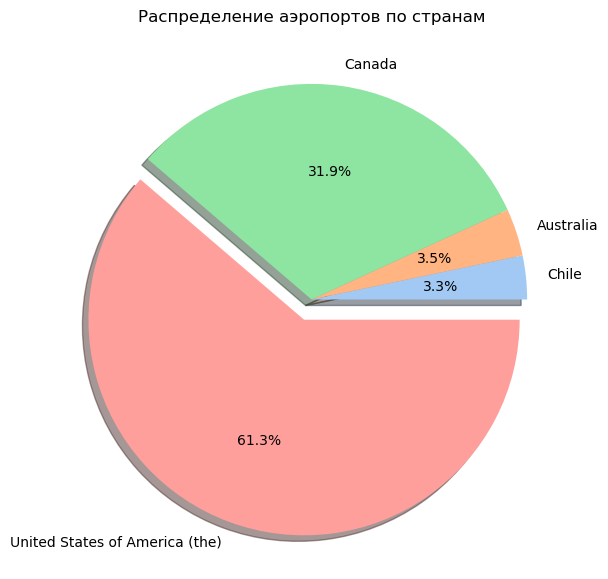

In [19]:
# создание круговой диаграммы
sns.set_palette('pastel')
explode = (0, 0, 0, 0.1)
plt.figure(figsize=(7, 7))
plt.pie(country['count'], labels = country['country'], autopct='%.1f%%', explode=explode, shadow=True)
plt.title('Распределение аэропортов по странам')
plt.show()

Из круговой диаграммы отчетливо видно, что подавляющее большинство аэропортов сосредоточено в США - 61.3% или 4 441 аэропорт.  
Следом идет Канада, здесь 31.9%(2 311 аэропортов) всех аэропортов.  
Австралия и Чили примерно равны - 3.5% и 3.3% аэропортов.

In [20]:
# создание таблицы с уникальными названиями аэропортов
covid_airport_unique = data[~data[["airport_name"]].duplicated()].reset_index(drop=True)

In [21]:
# создание карты с аэропортами по странам
f = folium.Figure(width=1000, height=400)
m = folium.Map([23.53,78.3], zoom_start=1).add_to(f)
cluster = MarkerCluster().add_to(m)

# пишем функцию, которая принимает строку датафрейма,
# создаёт маркер в текущей точке и добавляет его на карту
def create_cluster(row):
    Marker([row['lat'], row['lng']], 
           popup=f"{row['country']}{row['airport_name']}", 
           icon=folium.Icon(icon_color='red',icon ='plane',prefix='fa')).add_to(cluster)

# применяем функцию для создания кластера ко всем строкам датафрейма
covid_airport_unique.apply(create_cluster, axis=1)

m

На карте, меняя масштаб, можно увидеть как расположились аэропорты внутри стран.  
Карта наглядно подтверждает вывод о том, что большинство аэропортов сосредоточены в США. 

In [22]:
# создание сводной таблицы с группировкой по странам, городам, аэропортам и числом рейсов
data_air = data.groupby(['country', 'city', 'airport_name']).agg({'date':'count'})\
               .sort_values(by='date').reset_index()
data_air.columns = ['country', 'city', 'airport_name', 'count']
data_air

,country,city,airport_name,count
0,Canada,Leduc County,edmonton international,236
1,Chile,Santiago,santiago international airport,238
2,Canada,Halifax,halifax international,252
3,Australia,Sydney,kingsford smith,257
4,Canada,Mirabel,montreal mirabel,257
5,Canada,Hamilton,hamilton international,260
6,United States of America (the),SeaTac,seattle-tacoma international,261
7,United States of America (the),Romulus,detroit metropolitan wayne county,261
8,United States of America (the),Paradise,mccarran international,261
9,United States of America (the),Newark,newark liberty international,261


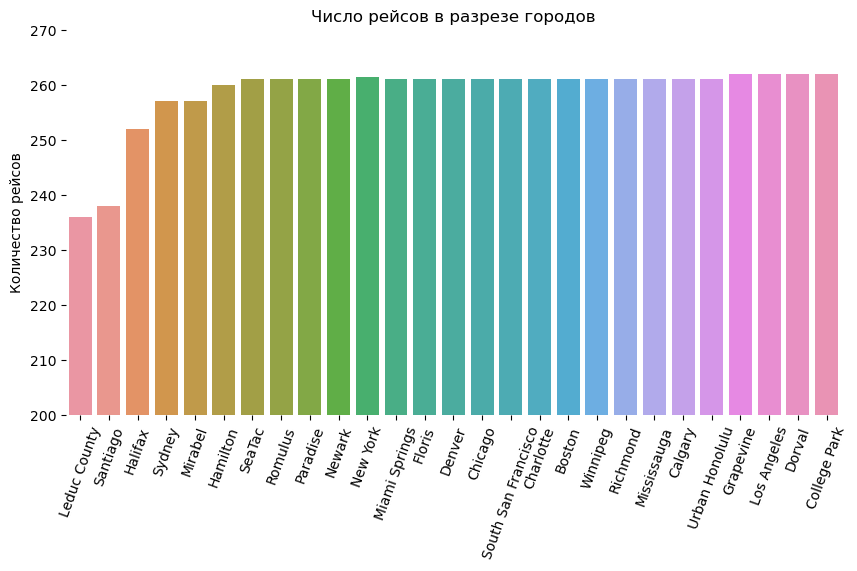

In [23]:
# построение диаграммы распределения рейсов по городам
sns.set_palette('Set2')
plt.figure(figsize=(10,5))
ax = sns.barplot(x='city', y='count', data=data_air, ci=None)
ax.set_title('Число рейсов в разрезе городов')
ax.set_xlabel('') 
ax.set_ylabel('Количество рейсов')
plt.xticks(rotation=70)
plt.ylim(200, 270)
sns.despine(left = True, bottom = True)
plt.show()

Меньше всего рейсов совершено в аэропорте Канады - edmonton international, город - Leduc County, а также аэропорте Чили - santiago international airport, город Santiago.  

Наибольшее число рейсов в аэропортах США - dallas/fort worth international(город Grapevine), los angeles international(Los Angeles), john f. kennedy international(New York), hartsfield-jackson atlanta international(College Park) и Канады - montreal trudeau(Dorval).

Рассмотрим, как распределились рейсы по месяцам и дням недели.

In [24]:
# создание сводных таблиц с распределением рейсов по месяцам и неделям
data_month = data.groupby('month').agg({'geography':'count'})
data_week = data.groupby('weekday').agg({'geography':'count'}).sort_values(by='geography')
data_month

,geography
month,
3,445
4,825
5,855
6,831
7,862
8,835
9,835
10,868
11,835


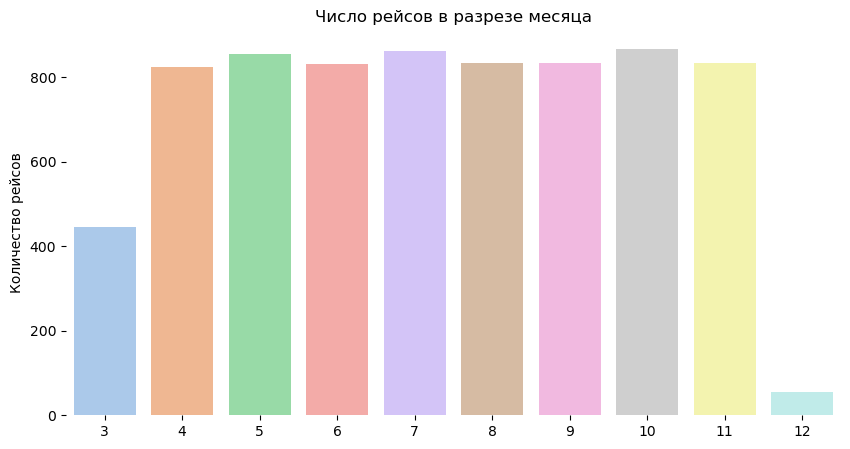

In [25]:
# построение графика распределения числа рейсов по месяцам
sns.set_palette('pastel')
plt.figure(figsize=(10,5))
ax = sns.barplot(x=data_month.index, y='geography', data=data_month, ci=None)
ax.set_title('Число рейсов в разрезе месяца')
ax.set_xlabel('') 
ax.set_ylabel('Количество рейсов')
sns.despine(left = True, bottom = True)
plt.show()

На диаграмме видно, что меньше всего рейсов совершено в декабре и марте 2020 года. Возможно, данные за зиму неполные, так как в таблице отсутствуют данные за январь и февраль вообще.

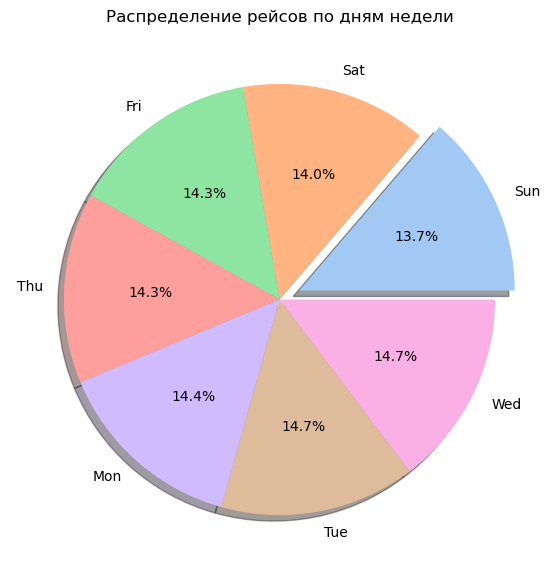

In [26]:
# построение круговой диаграммы числа рейсов по дням недели

sns.set_palette('pastel')
explode = (0.1, 0, 0, 0, 0, 0, 0)
plt.figure(figsize=(7, 7))
plt.pie(data_week['geography'], labels = data_week.index, autopct='%.1f%%', explode=explode, shadow=True)
plt.title('Распределение рейсов по дням недели')
plt.show()

В целом рейсы равномерно распределяются в течение недели, только в воскресенье чуть меньше, чем в остальные дни - 13.7%.  
Больше всего рейсов - во вторник и среду - 14.7%.

## Изменение числа рейсов в зависимости от месяца и дня недели

In [27]:
# создание таблицы с геометрией
geo_table = geo.GeoDataFrame(covid_airport_unique, 
                       geometry=geo.points_from_xy(covid_airport_unique.lng, covid_airport_unique.lat))
geo_table.sample(3)

,date,airport_name,percent_of_baseline,city,state,iso,country,geography,year,month,weekday,lng,lat,geometry
13,2020-06-14,denver international,30,Denver,Colorado,US-CO,United States of America (the),"POLYGON((-104.661254882812 39.8242265704646, -...",2020,6,Sun,-104.700316,39.864347,POINT (-104.70032 39.86435)
22,2020-04-26,mccarran international,22,Paradise,Nevada,US-NV,United States of America (the),"POLYGON((-115.158487558365 36.1007120735771, -...",2020,4,Sun,-115.148881,36.082854,POINT (-115.14888 36.08285)
16,2020-05-16,daniel k. inouye international,73,Urban Honolulu,Hawaii,US-HI,United States of America (the),"POLYGON((-157.926621437073 21.3389395547616, -...",2020,5,Sat,-157.918285,21.325965,POINT (-157.91829 21.32597)


In [28]:
# создание таблицы с геометрией континентов, стран
world = geo.read_file(geo.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


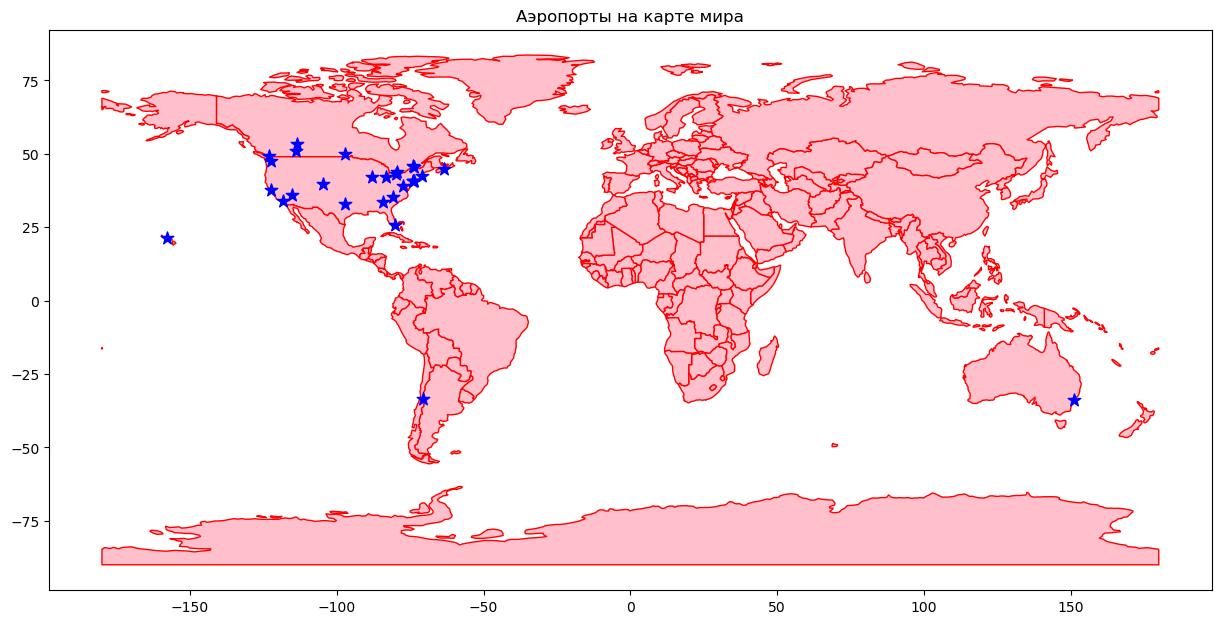

In [29]:
# карта мира с аэропортами
ax = world.plot(color='pink', edgecolor='red', figsize=(15, 10))
g = geo_table.plot(ax=ax, marker='*', color='blue', markersize=90)
g.set_title("Аэропорты на карте мира")
plt.show()

In [30]:
# сводная таблица со средним числом рейсов в месяце по сравнению с количеством рейсов в тот же месяц в базовом периоде
data_air_mean = data[['airport_name','month', 'percent_of_baseline']]\
                    .groupby(['airport_name', 'month']).agg({'percent_of_baseline':'mean'}).reset_index()

In [31]:
# объединение таблиц
data_air_mean = data_air_mean.merge(geo_table, on="airport_name")
data_air_mean = data_air_mean.rename(columns={"percent_of_baseline_x": "percent_mean"})
data_air_mean.head()

,airport_name,month_x,percent_mean,date,percent_of_baseline_y,city,state,iso,country,geography,year,month_y,weekday,lng,lat,geometry
0,boston logan international,3,80.687500,2020-04-03,56,Boston,Massachusetts,US-MA,United States of America (the),"POLYGON((-71.0050892829895 42.3472534332511, -...",2020,4,Fri,-71.010291,42.363633,POINT (-71.01029 42.36363)
1,boston logan international,4,59.900000,2020-04-03,56,Boston,Massachusetts,US-MA,United States of America (the),"POLYGON((-71.0050892829895 42.3472534332511, -...",2020,4,Fri,-71.010291,42.363633,POINT (-71.01029 42.36363)
2,boston logan international,5,56.709677,2020-04-03,56,Boston,Massachusetts,US-MA,United States of America (the),"POLYGON((-71.0050892829895 42.3472534332511, -...",2020,4,Fri,-71.010291,42.363633,POINT (-71.01029 42.36363)
3,boston logan international,6,61.766667,2020-04-03,56,Boston,Massachusetts,US-MA,United States of America (the),"POLYGON((-71.0050892829895 42.3472534332511, -...",2020,4,Fri,-71.010291,42.363633,POINT (-71.01029 42.36363)
4,boston logan international,7,65.354839,2020-04-03,56,Boston,Massachusetts,US-MA,United States of America (the),"POLYGON((-71.0050892829895 42.3472534332511, -...",2020,4,Fri,-71.010291,42.363633,POINT (-71.01029 42.36363)


In [32]:
# функция отрисовки карты в разрезе месяца
def create_geo_map(n, month):
    data_air_mean_month = data_air_mean[data_air_mean["month_x"]==n]
    gdf_data_air_mean_month = geo.GeoDataFrame(data_air_mean_month, 
                             geometry=geo.points_from_xy(data_air_mean_month.lng, data_air_mean_month.lat))
    print(gdf_data_air_mean_month['percent_mean'].mean())
    #print(gdf_data_air_mean_month.sort_values(by='percent_mean'))

    fig, ax = plt.subplots(figsize=(15, 10))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    world.plot(ax=ax, color='pink', edgecolor='black')
    geo_map = gdf_data_air_mean_month.plot(column='percent_mean', ax=ax, markersize=50, legend=True, cax=cax)
    geo_map.set_title(f"Средняя доля рейсов в {month} по сравнению с базовым периодом") 
    plt.show()

71.71830357142858


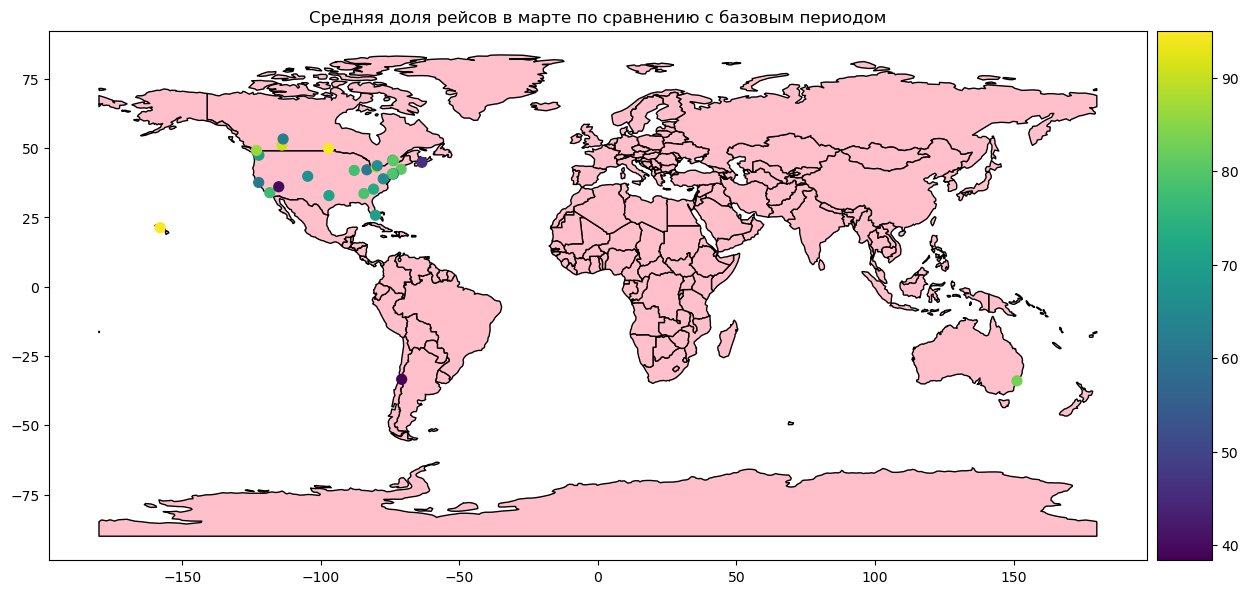

In [33]:
create_geo_map(3, 'марте')

Сильнее всего в марте сократились рейсы в аэропорте Чили - santiago international airport(штат Santiago Province), США - mccarran international (штат Nevada) и Канады -  halifax international (штат Nova Scotia). Здесь доля поездок сократилась более чем на 50 п.п.

И наоборот, практически не изменилось число рейсов в таких аэропортах как daniel k. inouye international (США, Hawaii) - 95% рейсов по сравнению с базовым периодом, winnipeg international (Канада, Manitoba) - 94.8%, calgary international (Канада, Alberta) - 90.6%. 
  
В целом число рейсов сократилось примерно на 30 п.п., средняя доля по всем аэропортам - около 70%

59.14441606001914


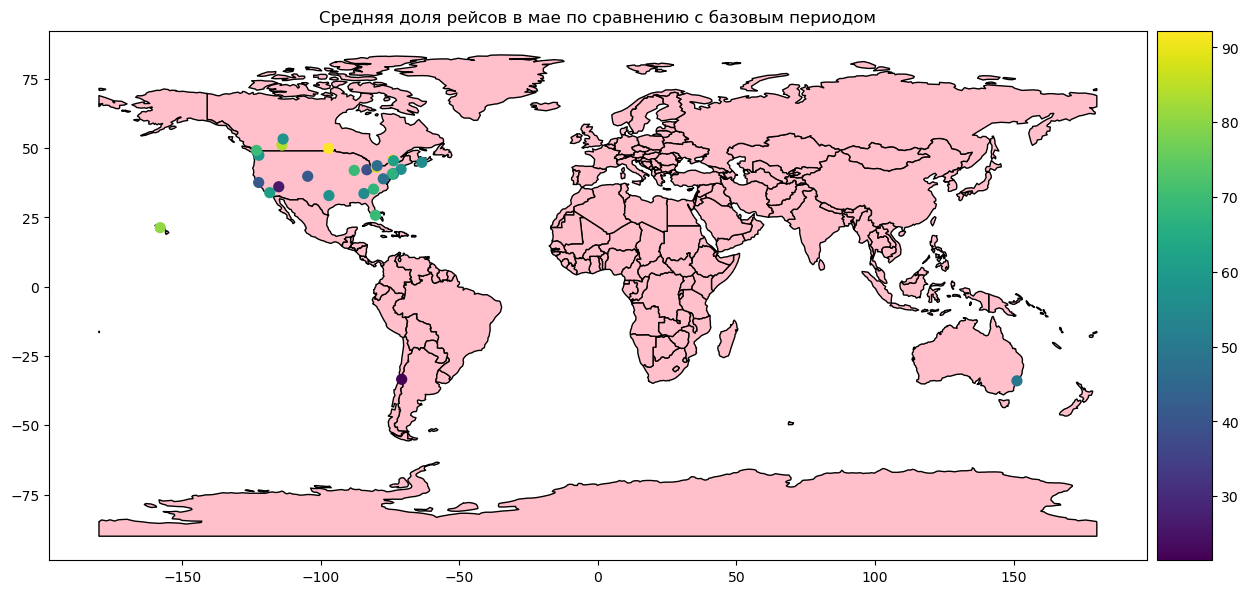

In [34]:
create_geo_map(5, 'мае')

Сильнее всего в мае сократились рейсы в аэропорте Чили - santiago international airport(штат Santiago Province), число рейсов по сравнению с базовым периодом составило 21%, США - mccarran international (штат Nevada) - 26% и detroit metropolitan wayne county (штат Michigan) - 39%. Здесь доля поездок сократилась более чем на 60 п.п.

И наоборот, практически не изменилось число рейсов в таких аэропортах как winnipeg international (Канада, Manitoba) - 92% рейсов по сравнению с базовым периодом, montreal mirabel (Канада, Quebec) - 90%, hamilton international (Канада, Ontario) - 87%.
  
Теперь ситуация изменилась, число рейсов в аэропортах сократилось сильнее и их доля составила 59% по сравнению с прошлым периодом. 

67.53714015178339


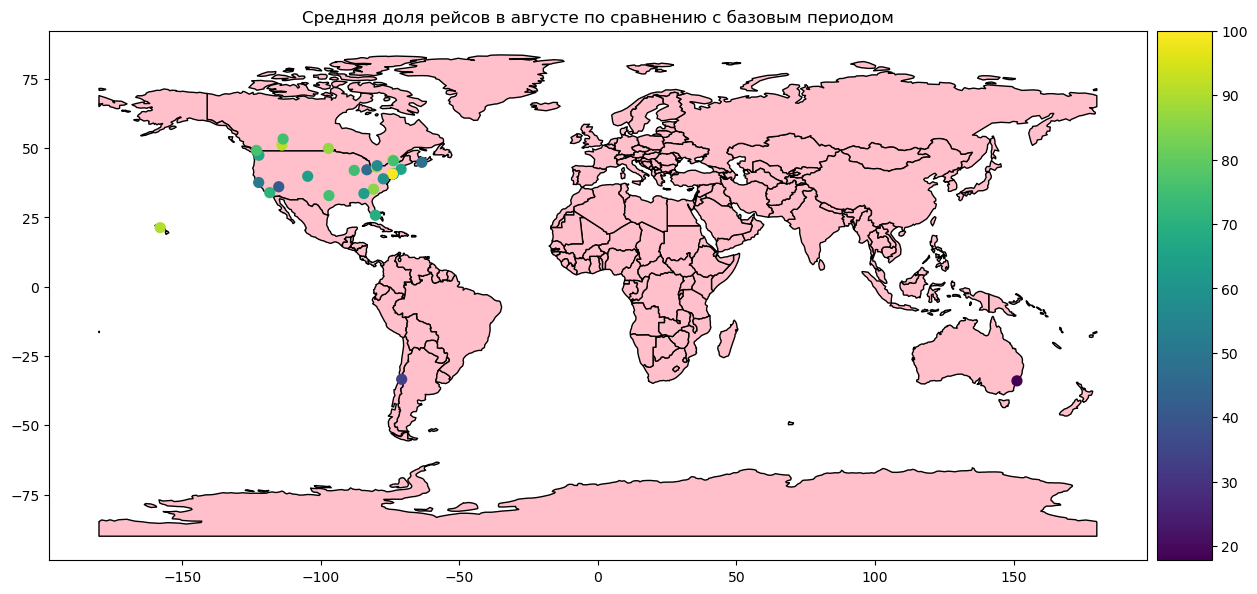

In [35]:
create_geo_map(8, 'августе')

Сильнее всего в мае сократились рейсы в аэропорте Австралии - kingsford smith(штат New South Wales), число рейсов по сравнению с базовым периодом составило 18%, Чили - santiago international airport (штат Santiago Province) - 33% и США - mccarran international (штат Nevada) - 41%.  
Стоит отметить значительное сокращение рейсов в аэропорте Австралии, тогда как в других странах число рейсов постепенно увеличивалось.  
  
И наоборот, практически не изменилось число рейсов в таких аэропортах как newark liberty international (США, New Jersey) - 100% рейсов по сравнению с базовым периодом, calgary international (Канада, Alberta) - 91%, montreal mirabel (Канада, Quebec) - 91%, daniel k. inouye international (США, Hawaii) - 90%.  
   
Средняя доля рейсов в аэропортах составила 67.5% по сравнению с прошлым периодом. 

71.97235023041473


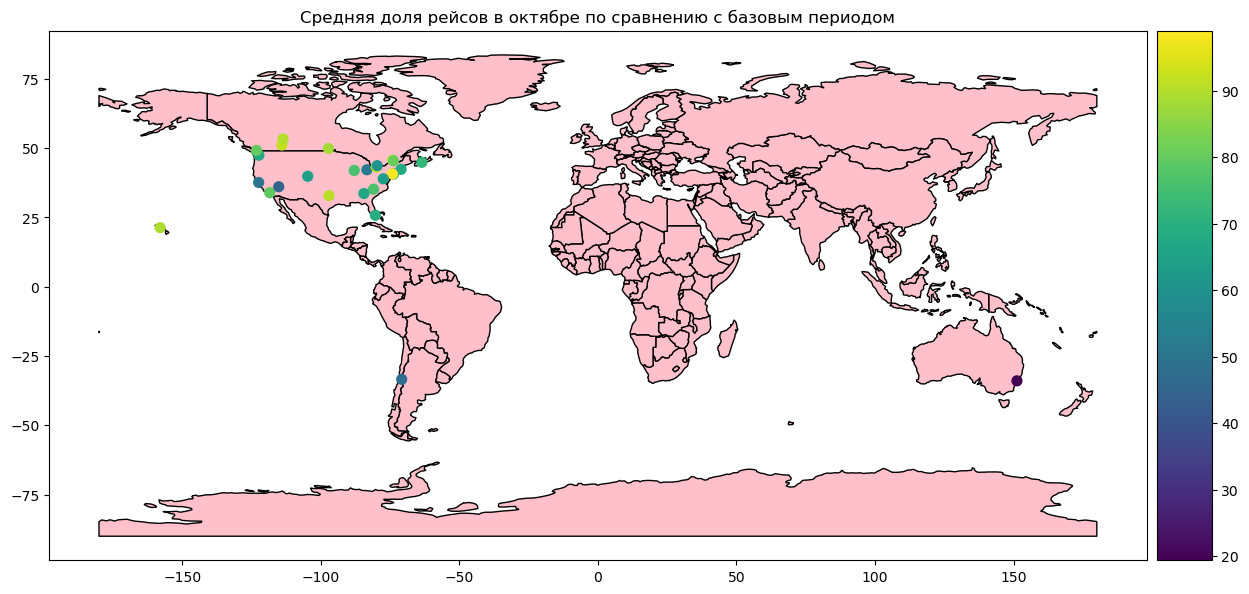

In [36]:
create_geo_map(10, 'октябре')

Сильнее всего в мае сократились рейсы в аэропорте Австралии - kingsford smith(штат New South Wales), число рейсов по сравнению с базовым периодом составило 19%,  США - mccarran international (штат Nevada) - 45% и Чили - santiago international airport (штат Santiago Province) - 48%.
Число рейсов в аэропортах продолжало увеличиваться, но в Австралии продолжало оставаться на самом низком уровне.

И наоборот, практически не изменилось число рейсов в таких аэропортах как newark liberty international (США, New Jersey) - 99% рейсов по сравнению с базовым периодом, hamilton international (Канада, Ontario) - 93%, calgary international (Канада, Alberta) - 92%.

Средняя доля рейсов в аэропортах составила 72% по сравнению с прошлым периодом.

77.08928571428571


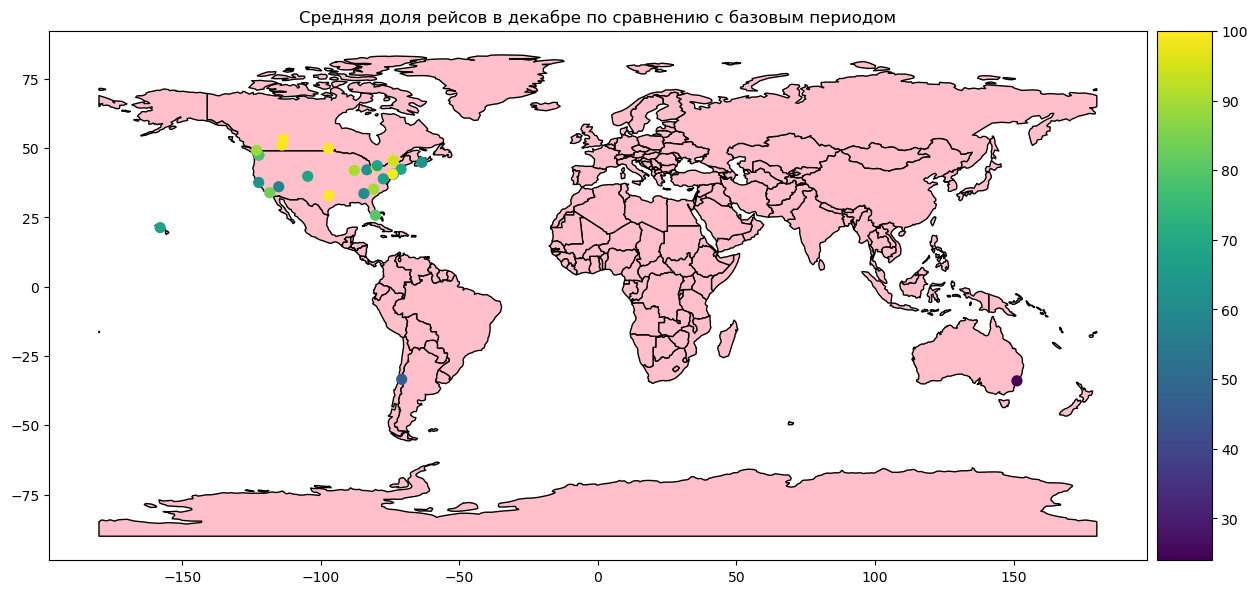

In [37]:
create_geo_map(12, 'декабре')

Сильнее всего в мае сократились рейсы в аэропорте Австралии - kingsford smith(штат New South Wales), число рейсов по сравнению с базовым периодом составило 24%, Чили - santiago international airport (штат Santiago Province) - 47% и США - mccarran international (штат Nevada) - 58%.  

Во многих аэропортах было восстановлено прежнее количество полетов (100%) - Канада - winnipeg international, hamilton international, montreal mirabel, edmonton international; США - newark liberty international, dallas/fort worth international.

Средняя доля рейсов в аэропортах составила 77% по сравнению с прошлым периодом. Стоит отметить, что количество рейсов постепенно увеличивается в аэропортах, имеет место положительная динамика.  
И хотя Австралия продолжает занимать последнюю строчку, но при этом число полетов постепенно и стабильно растет.

<p></p>

<div style="border:solid pink 5px; padding: 20px">
<b><span style="color:#FF78C4">Вывод:</span></b>   

<li>Основная доля трафика приходится на США и Канаду.</li>
<li>Меньше всего рейсов совершено в аэропорте Канады - edmonton international, город - Leduc County, а также аэропорте Чили - santiago international airport, город Santiago.</li>
<li>Наибольшее число рейсов в аэропортах США - dallas/fort worth international(город Grapevine), los angeles international(Los Angeles), john f. kennedy international(New York), hartsfield-jackson atlanta international(College Park) и Канады - montreal trudeau(Dorval).</li>
<li>Меньше всего рейсов совершено в декабре и марте 2020 года.</li>
<li>Больше всего полетов было в июле и октябре.</li>
<li>Рейсы равномерно распределены по дням недели, немного меньше полетов совершено в воскресенье, а лидер - вторник и среда.</li>
<li>Во время COVID сильнее всего сократились полеты в Австралию и Чили.</li>
</div>